In [1]:
! pip install kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!mkdir -p ~/.kaggle

In [4]:
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! pip install wandb weave

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 822.4/822.4 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 88.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 134.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 9.7 MB/s eta 0:00:00


In [7]:
!pip install torch-fidelity


In [8]:
! wandb login

wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: llodi22 (llodi22-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.fc1 = nn.Linear(1, dim)
        self.fc2 = nn.Linear(dim, dim)
    def forward(self, t):
        t = t.view(-1,1)
        h = F.relu(self.fc1(t))
        return F.relu(self.fc2(h))

class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, emb_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.emb_proj = nn.Linear(emb_dim, out_ch)
        self.gn1 = nn.GroupNorm(8, out_ch)
        self.gn2 = nn.GroupNorm(8, out_ch)
        self.skip = nn.Conv2d(in_ch, out_ch, 1) if in_ch!=out_ch else nn.Identity()

    def forward(self, x, emb):
        h = F.relu(self.gn1(self.conv1(x)))
        h = h + self.emb_proj(emb).view(emb.size(0), -1, 1, 1)
        h = self.gn2(self.conv2(h))
        return F.relu(h + self.skip(x))

class UNetScore(nn.Module):
    def __init__(self, base_ch=64):
        super().__init__()
        self.time_emb = TimeEmbedding(128)
        self.down1 = ResBlock(3, base_ch, 128)
        self.down2 = ResBlock(base_ch, base_ch*2, 128)
        self.down3 = ResBlock(base_ch*2, base_ch*4, 128)
        self.mid = ResBlock(base_ch*4, base_ch*4, 128)
        self.up3 = ResBlock(base_ch*8, base_ch*2, 128)
        self.up2 = ResBlock(base_ch*4, base_ch, 128)
        self.up1 = ResBlock(base_ch*2, base_ch, 128)
        self.out = nn.Conv2d(base_ch, 3, 3, padding=1)
        self.pool = nn.AvgPool2d(2)
        self.up = nn.Upsample(scale_factor=2)

    def forward(self, x, sigma):
        emb = self.time_emb(torch.log(sigma))
        d1 = self.down1(x, emb)
        d2 = self.down2(self.pool(d1), emb)
        d3 = self.down3(self.pool(d2), emb)
        mid = self.mid(self.pool(d3), emb)
        u3 = self.up3(torch.cat([self.up(mid), d3], 1), emb)
        u2 = self.up2(torch.cat([self.up(u3), d2], 1), emb)
        u1 = self.up1(torch.cat([self.up(u2), d1], 1), emb)
        return self.out(u1)


In [10]:
import numpy as np

def geometric_schedule(sigma_min, sigma_max, L):
    return np.exp(np.linspace(np.log(sigma_max), np.log(sigma_min), L))


In [11]:
def dsm_loss(model, x, sigmas):
    batch_size = x.size(0)

    # sample random noise level
    idx = torch.randint(0, len(sigmas), (batch_size,), device=x.device)
    sigma = sigmas[idx].view(batch_size, 1, 1, 1)

    noise = torch.randn_like(x)
    x_noisy = x + sigma * noise

    score = model(x_noisy, sigma.squeeze())

    target = -noise / sigma
    # σ² weighting (CRITICAL)
    loss = ((score - target) ** 2 * sigma**2).mean()
    return loss


In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = UNetScore().to(device)




In [14]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

loader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)


100%|██████████| 170M/170M [00:03<00:00, 44.3MB/s]


In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

ema_model = UNetScore().to(device)
ema_model.load_state_dict(model.state_dict())

def update_ema(model, ema_model, decay=0.999):
    with torch.no_grad():
        for p, ema_p in zip(model.parameters(), ema_model.parameters()):
            ema_p.data = decay * ema_p.data + (1 - decay) * p.data


In [16]:
import wandb

run = wandb.init(
    entity="llodi22-free-university-of-tbilisi-",
    project="CIFAR-10",
    config={
        "architecture": "NCSN-UNet",
        "dataset": "CIFAR-10",
        "epochs": 50,
        "noise_schedule": "geometric",
        "experiment": "Paper1_L_ablation"
    }
)


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.
wandb: Currently logged in as: llodi22 (llodi22-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [17]:
import os

checkpoint_dir = "/content/drive/MyDrive/Monet"
os.makedirs(checkpoint_dir, exist_ok=True)

def save_checkpoint(epoch):
    torch.save({
        "model": model.state_dict(),
        "ema_model": ema_model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "epoch": epoch
    }, f"{checkpoint_dir}/ncsn_epoch_{epoch}.pth")
    print("Checkpoint directory:", checkpoint_dir)

def load_checkpoint(path):
    ckpt = torch.load(path)
    model.load_state_dict(ckpt["model"])
    ema_model.load_state_dict(ckpt["ema_model"])
    optimizer.load_state_dict(ckpt["optimizer"])
    return ckpt["epoch"]




In [18]:
sigma_min, sigma_max, L = 0.01, 50.0, 10
sigmas_geom = torch.tensor(np.exp(np.linspace(np.log(sigma_max), np.log(sigma_min), L)), dtype=torch.float32, device=device)


In [19]:
epochs = 50
start_epoch = 1

for epoch in range(start_epoch, epochs+1):
    model.train()
    total = 0
    for x,_ in loader:
        x=x.to(device)
        loss = dsm_loss(model,x,sigmas_geom)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        update_ema(model, ema_model)
        total += loss.item()

    avg_loss = total/len(loader)
    print(f"Epoch {epoch+1} Loss {avg_loss}")
    wandb.log({"epoch": epoch+1, "train_loss": avg_loss})



Epoch 2 Loss 57.62258717806443
Epoch 3 Loss 1.0191697821287853
Epoch 4 Loss 1.0001520973337277
Epoch 5 Loss 0.9919171563499724
Epoch 6 Loss 0.8871769020929361
Epoch 7 Loss 0.724392376287514
Epoch 8 Loss 0.6528421664786765
Epoch 9 Loss 0.6074449305644121
Epoch 10 Loss 0.5704578756523864
Epoch 11 Loss 0.5512976202818439
Epoch 12 Loss 0.5335321539960554
Epoch 13 Loss 0.4991247964179729
Epoch 14 Loss 0.46497461131161744
Epoch 15 Loss 0.42180877405664197
Epoch 16 Loss 0.38641721635218473
Epoch 17 Loss 0.36600033866475
Epoch 18 Loss 0.354594406035855
Epoch 19 Loss 0.34216630550296717
Epoch 20 Loss 0.33289398645501
Epoch 21 Loss 0.3234715451060049
Epoch 22 Loss 0.3137691078893364
Epoch 23 Loss 0.30496207828564414
Epoch 24 Loss 0.2983780813872662
Epoch 25 Loss 0.2923745770969659
Epoch 26 Loss 0.28155173304135844
Epoch 27 Loss 0.27811892959467893
Epoch 28 Loss 0.2709965465395042
Epoch 29 Loss 0.2596832487894141
Epoch 30 Loss 0.2563322590059027
Epoch 31 Loss 0.24779018157583368
Epoch 32 Loss 0.2

In [20]:
def snr_step_size(sigma, sigma_min, base_eps=1e-5):
    return base_eps * (sigma / sigma_min) ** 2


In [21]:
@torch.no_grad()
def annealed_langevin(model, sigmas, steps_per_level=50):
    x = torch.randn(64,3,32,32).to(device)
    sigma_min = sigmas[-1]
    for sigma in sigmas:
        for _ in range(steps_per_level):
            score = model(x, torch.full((x.size(0),), sigma, device=device))
            alpha = 1e-5*(sigma/sigma_min)**2
            x = x + alpha*score + torch.sqrt(torch.tensor(2*alpha))*torch.randn_like(x)
    return x



In [22]:
from torch_fidelity import calculate_metrics
import torchvision.utils as vutils
import os
import shutil

/tmp/ipython-input-1327313334.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = x + alpha*score + torch.sqrt(torch.tensor(2*alpha))*torch.randn_like(x)
Creating feature extractor "inception-v3-compat" with features ['2048']
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 288MB/s]
Extracting statistics from input 1
Looking for samples non-recursivelty in "/content/L5" with extensions png,jpg,jpeg
Found 10000 samples
/usr/local/lib/python3.12/dist-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to yo

FID L=5: 455.8675705118188


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "/content/L10" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Extracting statistics from input 2
Processing samples
Caching /root/.cache/torch/fidelity_cache/cifar10-train-inception-v3-compat-features-2048.pt
Caching /root/.cache/torch/fidelity_cache/cifar10-train-inception-v3-compat-stat-fid-2048.pt
Frechet Inception Distance: 196.12871852477446


FID L=10: 196.12871852477446


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "/content/L20" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Extracting statistics from input 2
Processing samples
Caching /root/.cache/torch/fidelity_cache/cifar10-train-inception-v3-compat-features-2048.pt
Caching /root/.cache/torch/fidelity_cache/cifar10-train-inception-v3-compat-stat-fid-2048.pt


FID L=20: 178.60733989034526


Frechet Inception Distance: 178.60733989034526


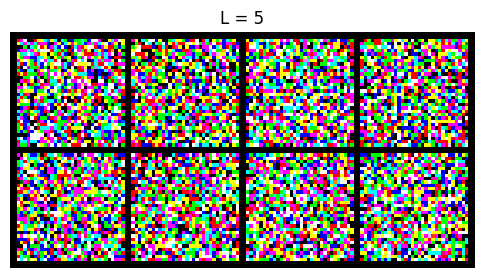

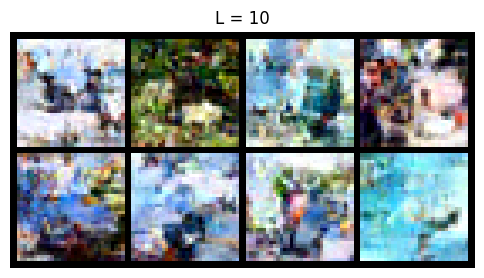

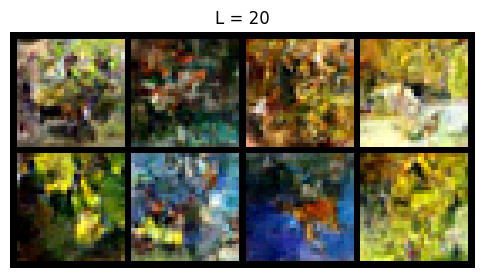

In [23]:
def generate_and_fid(L):
    sigmas = torch.tensor(geometric_schedule(sigma_min, sigma_max, L), dtype=torch.float32, device=device)
    out_dir = f"/content/L{L}"
    if os.path.exists(out_dir):
        shutil.rmtree(out_dir)
    os.makedirs(out_dir, exist_ok=True)
    count=0
    while count<10000:
        s = (annealed_langevin(ema_model, sigmas).clamp(-1,1)+1)/2
        for i in range(s.size(0)):
            if count >= 10000:
                break
            vutils.save_image(s[i], f"{out_dir}/{count}.png")
            count+=1

    os.system("rm -rf /root/.cache/torch/fidelity_cache")
    fid = calculate_metrics(input1=out_dir, input2='cifar10-train', fid=True, cuda=True)['frechet_inception_distance']
    wandb.log({f"FID_L{L}": fid})
    return fid

import matplotlib.pyplot as plt

def show_samples(model, sigmas, title):
    samples = annealed_langevin(model, sigmas)
    samples = (samples.clamp(-1,1) + 1) / 2
    grid = vutils.make_grid(samples[:8], nrow=4)

    plt.figure(figsize=(6,4))
    plt.title(title)
    plt.imshow(grid.permute(1,2,0).cpu())
    plt.axis('off')

for L in [5,10,20]:
    sigmas = torch.tensor(
        np.exp(np.linspace(np.log(sigma_max), np.log(sigma_min), L)),
        dtype=torch.float32,
        device=device
    )
    show_samples(ema_model, sigmas, f"L = {L}")


for L in [5,10,20]:
    fid = generate_and_fid(L)
    print(f"FID L={L}: {fid}")

In [24]:
wandb.finish()


FID_L10,▁
FID_L20,▁
FID_L5,▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
FID_L10,196.12872
FID_L20,178.60734
FID_L5,455.86757
epoch,51
train_loss,0.1794
